# Coverage/connectivity analysis
From the perspective of an assembly graph -- this notebook relates to the process of selecting genomes for further examination, and for describing the graph in a paper. We'll revisit coverage more closely for individual genomes / genes later on in a different notebook.

In [1]:
%run "Header.ipynb"

## Load graph
Parsing GFA file manually, since GfaPy takes a relatively long amount of time reading through it.

In [2]:
import networkx as nx
import matplotlib
from matplotlib import pyplot
from statistics import median

# Figure out where the assembly graph is located.
with open("../config/input-graph", "r") as gf:
    FILENAME = next(gf).strip()

# We ignore directionality for right now.
graph = nx.Graph()

with open(FILENAME, "r") as gfafile:
    for line in gfafile:
        # Parse sequences. We convert these to "nodes" in the networkx representation of the graph,
        # but they are really edges in the repeat graph produced by metaFlye.
        if line[0] == "S":
            parts = line.strip().split("\t")
            # Strip off the "edge_" name prefix -- turn "edge_123" into "123", for example
            node_name = parts[1][5:]
            node_len = len(parts[2])
            node_cov = None
            
            # Parse GFA tags
            extra_data = parts[3:]
            for tag in extra_data:
                # This behavior could 
                if tag.startswith("LN:i:"):
                    raise ValueError("Duplicate length for node {}".format(node_name))
                elif tag.startswith("dp:i:"):
                    if node_cov is None:
                        node_cov = int(tag[5:])
                    else:
                        raise ValueError("Duplicate coverage for node {}".format(node_name))
                        
            if node_cov is None:
                raise ValueError("No coverage tag given for node {}".format(node_name))
                
            graph.add_node(node_name, length=node_len, cov=node_cov)
            
        # Parse links between sequences.
        # Each link line looks something like:
        #
        # L    edge_74133    -    edge_71431    -    0M
        #
        # (where the whitespace gaps are each a single tab character)
        elif line[0] == "L":
            parts = line.strip().split("\t")
            # Again, the [5:] slices are needed to remove the "edge_" prefix.
            src = parts[1][5:]
            snk = parts[3][5:]
            # As mentioned, we ignore directionality for this specific application. So, e.g.:
            # A+ -> B+
            # A+ -> B-
            # A- -> B+
            # A- -> B-
            # ... would all get treated as the same edge. "Duplicate" edges are implicitly ignored by networkx.
            graph.add_edge(src, snk)

print("Graph contains {} edges (represented as GFA segments).".format(graph.number_of_nodes()))
print("Graph contains {} links between edges (ignoring directionality for now).".format(graph.number_of_edges()))
print("Graph contains {} connected components.".format(nx.number_connected_components(graph)))

Graph contains 78793 edges (represented as GFA segments).
Graph contains 4299697 links between edges (ignoring directionality for now).
Graph contains 45988 connected components.


## Compute coverage statstics for each component

In [3]:
# Sort components by number of edges.
node2len = nx.get_node_attributes(graph, "length")
node2cov = nx.get_node_attributes(graph, "cov")
sorted_components = sorted(
    nx.connected_components(graph),
    key=len,
    reverse=True
)

node2cmp = {}
cmp2totalLen = {}
cmp2meanCov = {}
cmp2medianCov = {}
cmp2cov = {}
for i, cmp in enumerate(sorted_components):
    for node in cmp:
        node2cmp[node] = i + 1
            
    cmp2cov[i] = [node2cov[node] for node in cmp]
    cmp2totalLen[i] = sum([node2len[node] for node in cmp])
    cmp2meanCov[i] = sum(cmp2cov[i]) / len(cmp)
    cmp2medianCov[i] = median(cmp2cov[i])
    # https://stackoverflow.com/a/10742904/10730311
    cmpNum = "{:,}".format(i + 1).ljust(6, " ")
    print("Component #{}: {} edges, total length {:,}, mean coverage {:.2f}x, median coverage {:.2f}x, has edge {}".format(
        # https://stackoverflow.com/a/59841/10730311
        cmpNum, len(cmp), cmp2totalLen[i], cmp2meanCov[i], cmp2medianCov[i], next(iter(cmp))
    ))

Component #1     : 21750 edges, total length 1,787,131,875, mean coverage 2568.90x, median coverage 26.00x, has edge 20257
Component #2     : 252 edges, total length 3,799,366, mean coverage 83.16x, median coverage 29.50x, has edge 30703
Component #3     : 167 edges, total length 1,946,111, mean coverage 153.16x, median coverage 12.00x, has edge 22865
Component #4     : 109 edges, total length 5,305,423, mean coverage 37.60x, median coverage 26.00x, has edge 10661
Component #5     : 88 edges, total length 7,916,783, mean coverage 60.06x, median coverage 25.00x, has edge 13686
Component #6     : 69 edges, total length 2,717,644, mean coverage 15.75x, median coverage 13.00x, has edge 24121
Component #7     : 53 edges, total length 4,491,766, mean coverage 17.43x, median coverage 15.00x, has edge 8086
Component #8     : 53 edges, total length 96,799, mean coverage 72.15x, median coverage 48.00x, has edge 22961
Component #9     : 49 edges, total length 3,365,768, mean coverage 129.16x, med

## Compute entire-graph coverage statistics

In [4]:
covs = node2cov.values()
print("Minimum coverage: {}".format(min(covs)))
print("Maximum coverage: {}\n".format(max(covs)))
print("Average coverage: {:.2f}".format(sum(covs) / len(covs)))
print("Median coverage: {}\n".format(median(covs)))
    
num_nodes_w_1mil_cov = 0
for n in node2cov.keys():
    if node2cov[n] >= 1000000:
        num_nodes_w_1mil_cov += 1
        print(n, node2cov[n], node2cmp[n])
print("Number of edges with coverage >= 1 million: {}\n".format(num_nodes_w_1mil_cov))

print("===MAX COVERAGE EDGES===")
max_cov_nodes = sorted(node2cov.keys(), key=lambda node: node2cov[node], reverse=True)
for i in range(10):
    node = max_cov_nodes[i]
    print(
        "{}. Edge {} has a coverage of {:,}. {} neighbors. In cmp {}. Length {:,}.".format(
            i + 1, node, node2cov[node], len(graph.adj[node]), node2cmp[node], node2len[node]
        )
    )
    
# (Allowing self edges, tho)
print("\n===MAX COVERAGE EDGES (just isolated ones)===")
max_cov_isolated_nodes = list(
    filter(
        lambda node: len(set(graph.adj[node]) - set([node])) == 0,
        max_cov_nodes
    )
)
for i in range(10):
    node = max_cov_isolated_nodes[i]
    print(
        "{}. Edge {} has a coverage of {:,}. In cmp {}. Length {:,}.".format(
            i + 1, node, node2cov[node], node2cmp[node], node2len[node]
        )
    )

Minimum coverage: 0
Maximum coverage: 7536987

Average coverage: 951.31
Median coverage: 14

214 1113087 1
4329 7536987 1
4331 5480102 1
4339 4096911 1
4343 2508091 1
4345 2744133 1
6315 2104237 1
8115 1277953 124
9654 2075349 431
9904 1844273 1
Number of edges with coverage >= 1 million: 10

===MAX COVERAGE EDGES===
1. Edge 4329 has a coverage of 7,536,987. 61 neighbors. In cmp 1. Length 580.
2. Edge 4331 has a coverage of 5,480,102. 61 neighbors. In cmp 1. Length 611.
3. Edge 4339 has a coverage of 4,096,911. 61 neighbors. In cmp 1. Length 541.
4. Edge 4345 has a coverage of 2,744,133. 61 neighbors. In cmp 1. Length 532.
5. Edge 4343 has a coverage of 2,508,091. 61 neighbors. In cmp 1. Length 568.
6. Edge 6315 has a coverage of 2,104,237. 134 neighbors. In cmp 1. Length 575.
7. Edge 9654 has a coverage of 2,075,349. 6 neighbors. In cmp 431. Length 602.
8. Edge 9904 has a coverage of 1,844,273. 39 neighbors. In cmp 1. Length 544.
9. Edge 8115 has a coverage of 1,277,953. 11 neighbors.

## Find long (>= 1 million bp) and high-coverage (>= 100x) edges in simple areas of the graph

(Good candidates for constructing mutation spectra.)

In [5]:
good_nodes = filter(lambda node: node2len[node] >= 1000000, max_cov_nodes)
good_nodes = filter(lambda node: node2cov[node] >= 100, good_nodes)
good_nodes = filter(lambda node: node2cmp[node] != 1, good_nodes)
for i, node in enumerate(good_nodes):
    cmp = node2cmp[node]
    neighbors = set(graph.adj[node]) - set([node])
    print(
        "{}. Edge {} has a coverage of {:,} and length of {:,}. {} neighbors, ignoring self-edges. In component {}.".format(
            i + 1, node, node2cov[node], node2len[node], len(neighbors), cmp
        )
    )

1. Edge 6104 has a coverage of 4,166 and length of 1,289,244. 12 neighbors, ignoring self-edges. In component 19.
2. Edge 2358 has a coverage of 2,930 and length of 2,806,161. 0 neighbors, ignoring self-edges. In component 3273.
3. Edge 1671 has a coverage of 1,433 and length of 2,153,394. 0 neighbors, ignoring self-edges. In component 3131.
4. Edge 16244 has a coverage of 1,307 and length of 2,448,520. 0 neighbors, ignoring self-edges. In component 8044.
5. Edge 4773 has a coverage of 1,182 and length of 1,371,455. 0 neighbors, ignoring self-edges. In component 3857.
6. Edge 11863 has a coverage of 1,164 and length of 2,597,011. 0 neighbors, ignoring self-edges. In component 6463.
7. Edge 4811 has a coverage of 609 and length of 1,166,051. 0 neighbors, ignoring self-edges. In component 3869.
8. Edge 1288 has a coverage of 526 and length of 3,430,435. 0 neighbors, ignoring self-edges. In component 3063.
9. Edge 10177 has a coverage of 520 and length of 1,515,080. 1 neighbors, ignoring 

## Finding certain edges -- and output GFA files for their components

To make it easy to show the topology of these components.

In [6]:
for e in ("6104", "1671", "2358"):
    print(e, "in the {:,}-th largest cc".format(node2cmp[e]))
    cc_subg = graph.subgraph(sorted_components[node2cmp[e] - 1])
    gfa_out = ""
    # sort the nodes so that this file is deterministically ordered
    for n in sorted(cc_subg.nodes):
        gfa_out += f"S\tedge_{n}\t*\tLN:i:{node2len[n]}\tdp:i:{node2cov[n]}\n"
        
    # Just yeet in the edges from the original gfa so you can be faithful to orientation.
    # This is a very lazy way to do this, but I am also a very lazy human being so it evens out.
    with open(FILENAME, "r") as gfafile:
        for line in gfafile:
            if line[0] == "L":
                if line.split()[1][5:] in cc_subg.nodes:
                    gfa_out += line
    with open(f"graphs/asmgraph_{e}_cc{node2cmp[e]}.gfa", "w") as outgfafile:
        outgfafile.write(gfa_out)

6104 in the 19-th largest cc
1671 in the 3,131-th largest cc
2358 in the 3,273-th largest cc


## Plot a summary of length and coverage for each component

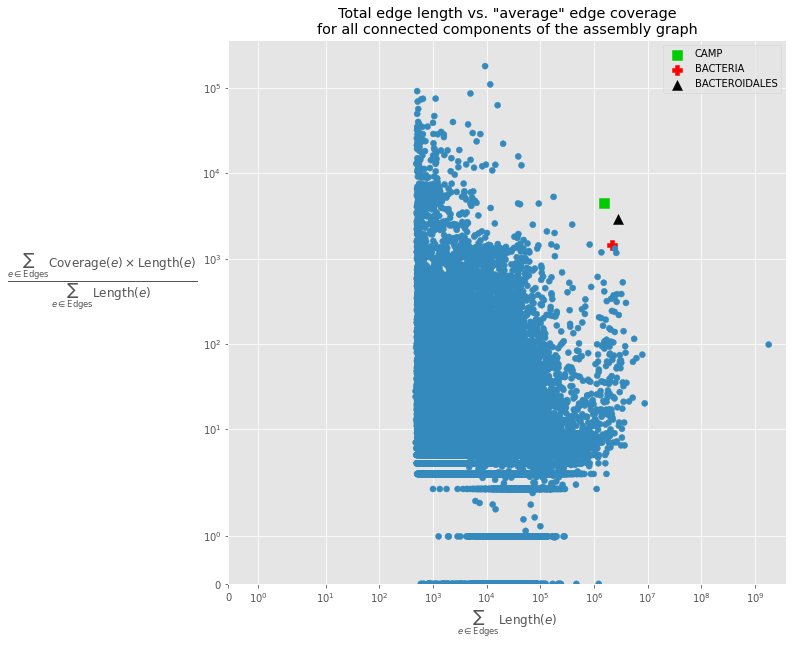

In [7]:
cc_lengths = []
cc_avg_covs = []
cc_colors = []

edge2color = {"6104": "#00cc00", "1671": "#ff0000", "2358": "#880088"}
edge2marker = {"6104": "s", "1671": "P", "2358": "^"}
    
fig, ax = pyplot.subplots(1)
for i, cmp in enumerate(sorted_components):
    color = SCATTERPLOT_PT_COLOR
    total_edge_len = 0
    cov_times_len_for_all_edges = 0
    
    found_node_in_cc = None
    
    for node in cmp:
        total_edge_len += node2len[node]
        cov_times_len_for_all_edges += (node2len[node] * node2cov[node])
        # Color this cmp specially if it contains one of the edges we care about.
        # NOTE that the behavior of this is undefined if this contains more than one of these "special" edges
        # (this shouldn't be the case, since each edge we care about should be in a diff component).
        if node in edge2color:
            color = edge2color[node]
            found_node_in_cc = node
            
    # There isn't a way to assign different markers to different points in the same ax.scatter() command.
    # However, calling ax.scatter() once for each point in this plot takes forever on my laptop, since there are
    # a ton of points here! So we can get the best of both worlds (*and* still use a label for these N ccs,
    # like in the Within-Gene plots notebook) only calling ax.scatter() N+1 times: once for the N ccs we want to
    # highlight and label uniquely, and then once for all the other ccs.
    # See https://stackoverflow.com/a/43622421.
    if found_node_in_cc is not None:
        
        cc_for = seq2name[f"edge_{found_node_in_cc}"]
        ax.scatter(
            total_edge_len, cov_times_len_for_all_edges / total_edge_len,
            c=color, marker=edge2marker[found_node_in_cc], s=100, label=cc_for
        )        
    elif i == 0:
        # Highlight the hairball component.
        # Note that, of course, if the hairball component CONTAINS one of the special edges we highlighted just
        # now, then that styling will trump this... But really, we shouldn't be using genomes from within the
        # hairball component! For this analysis, at least :)
        ax.scatter(
            total_edge_len, cov_times_len_for_all_edges / total_edge_len,
            c="#000000", marker="$\\ast$", s=100, label='"Hairball" component'
        )
    else:
        cc_lengths.append(total_edge_len)
        cc_avg_covs.append(cov_times_len_for_all_edges / total_edge_len)
        cc_colors.append(color)

ax.scatter(cc_lengths, cc_avg_covs, c=cc_colors)
ax.set_title("Total edge length vs. \"average\" edge coverage\nfor all connected components of the assembly graph")
ax.set_xlabel("$\sum_{e \in \mathrm{Edges}} \mathrm{Length}(e)$")
ax.set_ylabel("$\\dfrac{\sum_{e \in \mathrm{Edges}} \mathrm{Coverage}(e) \\times \mathrm{Length}(e)}{\sum_{e \in \mathrm{Edges}} \mathrm{Length}(e)}$", rotation=0, labelpad=100)
ax.set_xscale("symlog")
ax.set_yscale("symlog")
ax.set_xlim(0)
ax.set_ylim(0)
ax.axvline(x=(10**6), color="#000000", linestyle="-.", label="Length cutoff: 1 Mbp")
ax.axhline(y=(10**3), color="#000000", linestyle="--", label="Coverage cutoff: 1,000x")
ax.legend()
fig.set_size_inches(10, 10)
fig.savefig("figs/cc_len_cov_summary.png", bbox_inches="tight")

## Visualize histogram of average coverage by component

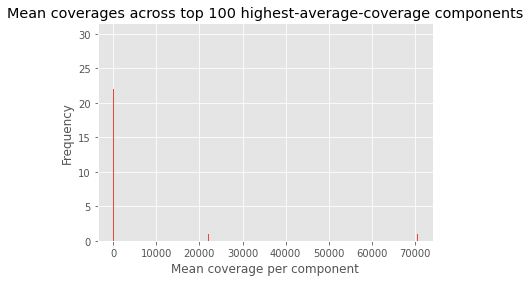

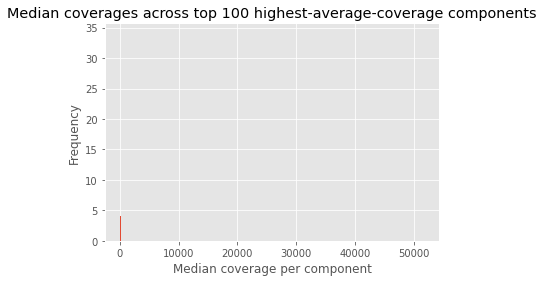

In [8]:
%matplotlib inline

pyplot.hist(x=[cmp2meanCov[c] for c in range(100)], bins="auto")
pyplot.xlabel("Mean coverage per component")
pyplot.ylabel("Frequency")
pyplot.title("Mean coverages across top 100 highest-average-coverage components")
pyplot.show()

pyplot.hist(x=[cmp2medianCov[c] for c in range(100)], bins="auto")
pyplot.xlabel("Median coverage per component")
pyplot.ylabel("Frequency")
pyplot.title("Median coverages across top 100 highest-average-coverage components")
pyplot.show()

## Visualize coverage histograms for the top $N$ components by mean coverage

In [9]:
# ... I don't remember the exact reason I chose 72 for this. The following plots/etc. aren't used in the paper,
# anyway, so it isn't a huge deal.
N = 72

Histogram code adapted from [this article](https://realpython.com/python-histograms/#visualizing-histograms-with-matplotlib-and-pandas).

Update: Commented this out for now since this cell takes a while and I don't need these plots any more.

In [10]:
# %matplotlib inline
# import math

# for i in range(N):
#     noun = "edge" if len(cmp2cov[i]) == 1 else "edges"
#     title = "Coverages: Component #{}\n{:,} {}; total length {:,}; mean coverage {:.2f}x".format(
#         i + 1, len(cmp2cov[i]), noun, cmp2totalLen[i], cmp2meanCov[i]
#     )
#     pyplot.hist(x=cmp2cov[i], bins="auto")
        
#     pyplot.xlabel("Coverage")
#     pyplot.ylabel("Frequency")
#     pyplot.title(title)
#     pyplot.show()

## How many of the top $N$ components contain just 1 edge?

In [11]:
num_1_edge_cmps = 0
for i in range(N):
    if len(cmp2cov[i]) == 1:
        num_1_edge_cmps += 1
print("{} of the top {} components have just 1 edge.".format(num_1_edge_cmps, N))

0 of the top 72 components have just 1 edge.


## For all components, plot number of edges vs. mean coverage

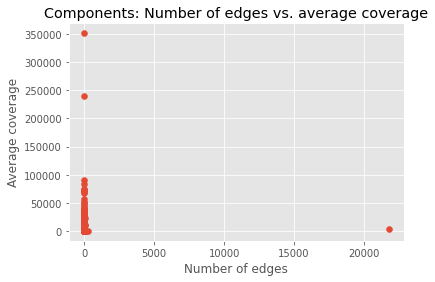

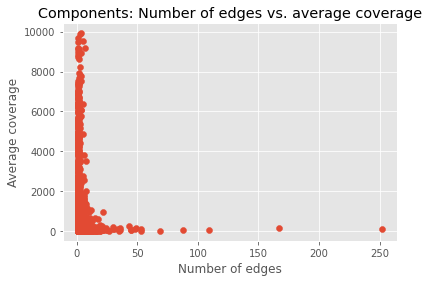

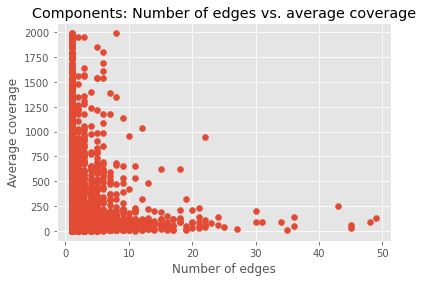

In [12]:
for cutoffs in [ [float("inf"), float("inf")], [1000, 10000], [50, 2000] ]:
    num_edges = []
    mean_cov = []
    for i, cmp in enumerate(sorted_components):
        ne = len(cmp)
        mc = cmp2meanCov[i]
        if ne < cutoffs[0] and mc < cutoffs[1]:
            num_edges.append(ne)
            mean_cov.append(mc)

    pyplot.scatter(x=num_edges, y=mean_cov)
    pyplot.title("Components: Number of edges vs. average coverage")
    pyplot.xlabel("Number of edges")
    pyplot.ylabel("Average coverage")
    pyplot.show()

## Prove that for every edge E in the graph, E and -E are not in the same weakly connected component

In [13]:
# We ignore directionality for right now
newgraph = nx.DiGraph()

def invert_orient(orient):
    if orient == "+":
        return "-"
    elif orient == "-":
        return "+"
    else:
        raise ValueError("Invalid orienatation {}".format(orient))

# Load graph in "double" mode, i.e. treating each edge's + and - as two objects.
# Similar to Bandage's "double" mode, or MetagenomeScope's default.
        
with open(FILENAME, "r") as gfafile:
    for line in gfafile:
        if line[0] == "S":
            parts = line.strip().split("\t")
            node_name = parts[1][5:]
            newgraph.add_node(node_name + "+", length=node_len, cov=node_cov)
            newgraph.add_node(node_name + "-", length=node_len, cov=node_cov)
        elif line[0] == "L":
            parts = line.strip().split("\t")
            src = parts[1]
            src_orient = parts[2]
            snk = parts[3]
            snk_orient = parts[2]
            
            newgraph.add_edge(src + src_orient, snk + snk_orient)
            newgraph.add_edge(snk + invert_orient(snk_orient), src + invert_orient(src_orient))

In [14]:
new_sorted_components = sorted(
    nx.weakly_connected_components(newgraph),
    key=len,
    reverse=True
)
for cmp in new_sorted_components:
    for node in cmp:
        rc = node[:-1] + invert_orient(node[-1])
        if rc in cmp:
            raise ValueError(f"{node} and {rc} in same weakly connected component!")